# Experiment with UNet Training

## Validate Test Sample

Look at the sampled test patch using balanced sampling methods. Make sure that input and label match.

In [1]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import xarray as xr
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from rattlinbog.estimators.apply import apply
from rattlinbog.estimators.base import ValidationLogging, ImageLogging
from rattlinbog.estimators.nn_estimator import LogConfig
from rattlinbog.estimators.wetland_classifier import WetlandClassifier
from rattlinbog.evaluate.image_producer_from_data_array import ImageProducerFromDataArray
from rattlinbog.evaluate.validator_of_dataset import ValidatorOfDataset
from rattlinbog.sampling.sample_patches_from_dataset import sample_patches_from_dataset
from rattlinbog.th_extensions.nn.unet import UNet
from rattlinbog.th_extensions.utils.data.streamed_xarray_dataset import StreamedXArrayDataset
from rattlinbog.th_extensions.utils.dataset_splitters import split_to_params_and_ground_truth, GROUND_TRUTH_KEY, \
    PARAMS_KEY

In [3]:
TEST_PATCH = Path("/home/braml/code/github/use-case-wetland-water-stress/tests/resources/approved/test_stochastic_training.test_stochastic_patch_samples_from_dataset.received.zarr")

In [4]:
test_patch = xr.open_zarr(TEST_PATCH)
test_patch

<xarray.Dataset>
Dimensions:          (axes: 2, y: 32, x: 32, parameter: 9, pos: 16)
Coordinates:
  * axes             (axes) <U1 'y' 'x'
    band             int64 ...
  * parameter        (parameter) <U14 'SIG0-HPAR-C1' ... 'SIG0-HPAR-STD'
  * pos              (pos) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x                (x) float64 5.288e+06 5.288e+06 ... 5.289e+06 5.289e+06
  * y                (y) float64 1.606e+06 1.606e+06 ... 1.606e+06 1.606e+06
Data variables:
    mask             (y, x) float32 dask.array<chunksize=(32, 32), meta=np.ndarray>
    params           (parameter, y, x) float32 dask.array<chunksize=(9, 32, 32), meta=np.ndarray>
    sampled_indices  (axes, pos) int64 dask.array<chunksize=(2, 16), meta=np.ndarray>
    spatial_ref      int64 ...
Attributes:
    name:     sample_0

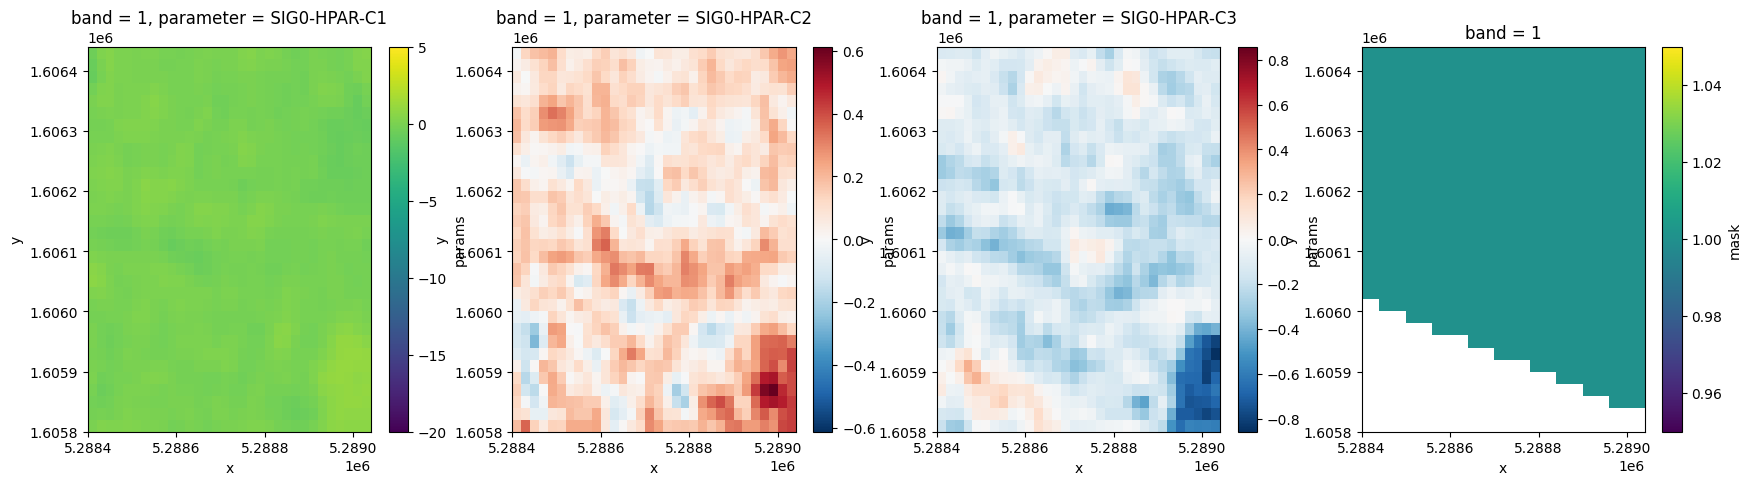

In [5]:
_, axes = plt.subplots(ncols=4, figsize=(21, 5))
test_patch['params'][0, ...].plot(ax=axes[0], vmin=-20, vmax=5)
test_patch['params'][1, ...].plot(ax=axes[1])
test_patch['params'][2, ...].plot(ax=axes[2])
test_patch['mask'].plot(ax=axes[3])
plt.draw()

## Test Data Loading

In [2]:
train_ds = xr.open_zarr("/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E051N015T3/SIG0-HPAR-MASK____RAMSAR-AT-01-ROI-8000-0-7000-15000_E051N015T3_EU020M__.zarr/")
valid_ds = xr.open_zarr("/data/wetland/hparam/V1M0R1/EQUI7_EU020M/E051N015T3/SIG0-HPAR-MASK____RAMSAR-AT-01-ROI-0-0-8000-15000_E051N015T3_EU020M__.zarr/")
train_ds[GROUND_TRUTH_KEY].min().values.item()

0.0

In [3]:
param_selection = ['SIG0-HPAR-PHS', 'SIG0-HPAR-AMP', 'SIG0-HPAR-M0']
train_ds = train_ds.sel(parameter=param_selection)
valid_ds = valid_ds.sel(parameter=param_selection)

In [4]:
ROI_ROW_MIN = 6000
ROI_ROW_MAX = 8000
ROI_COL_MIN = 9000
ROI_COL_MAX = 11000
validation_roi = valid_ds.isel(y=slice(ROI_ROW_MIN, ROI_ROW_MAX), x=slice(ROI_COL_MIN, ROI_COL_MAX))

In [ ]:
def normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val)

phs_min = train_ds[PARAMS_KEY][0].min().values.item()
phs_max = train_ds[PARAMS_KEY][0].max().values.item()

def preprocess_rgb_comp(x):
    o = x.copy()
    o[0, ...] = (normalize(x[0], phs_min, phs_max) * 356) / 255.0
    o[1, ...] = (10 ** (x[1] / 10.0)) / 255.0
    o[2, ...] = x[2] / 255.0
    return o

train_ds[PARAMS_KEY] = train_ds[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=train_ds[PARAMS_KEY])
validation_roi[PARAMS_KEY] = validation_roi[PARAMS_KEY].map_blocks(preprocess_rgb_comp, template=validation_roi[PARAMS_KEY])

In [6]:
validation_roi = validation_roi.persist()

In [7]:
train_ds = train_ds.persist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


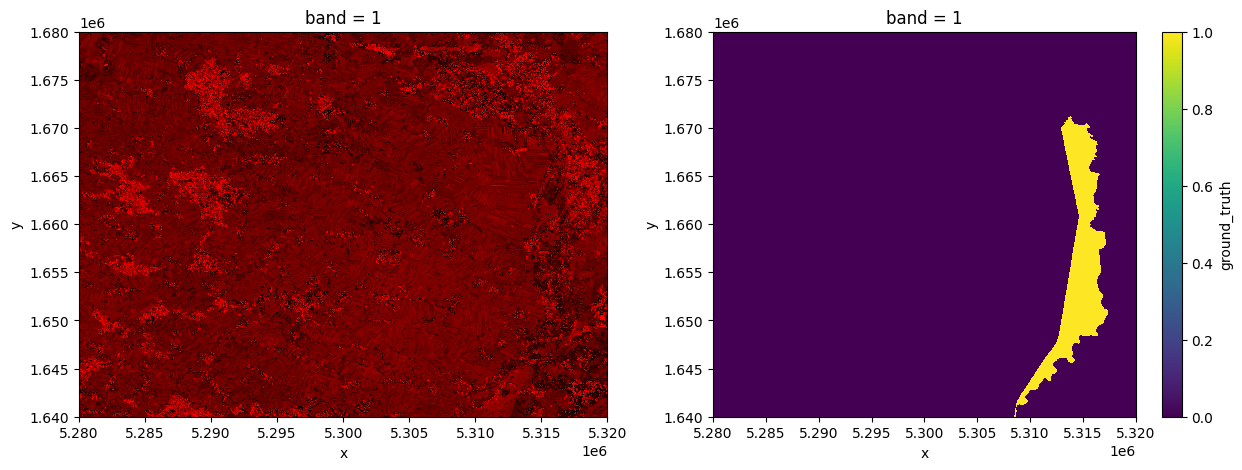

In [8]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
validation_roi[PARAMS_KEY].plot.imshow(ax=axes[0])
validation_roi[GROUND_TRUTH_KEY].plot(ax=axes[1])
plt.draw()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


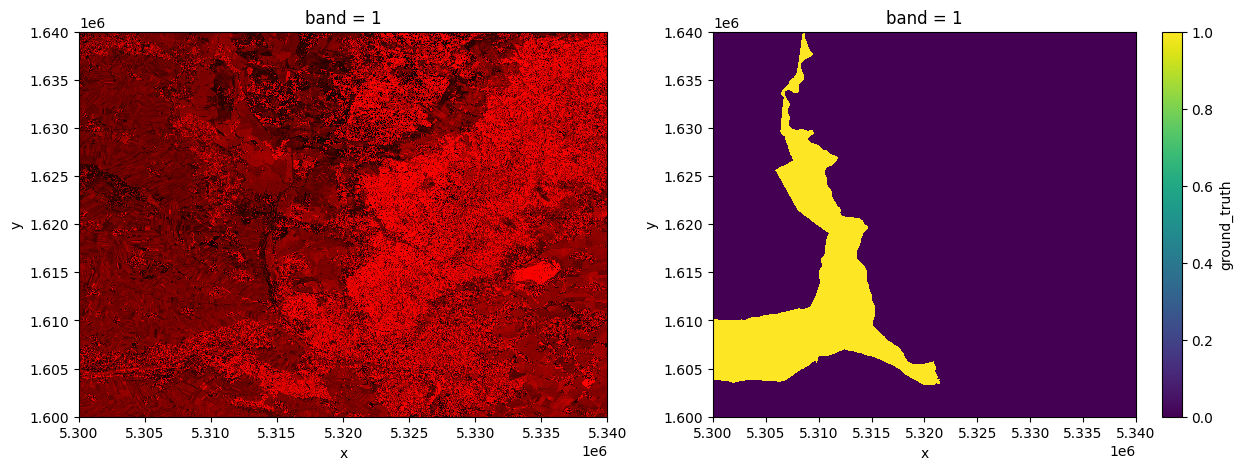

In [9]:
_, axes = plt.subplots(ncols=2, figsize=(15, 5))
train_ds[PARAMS_KEY][:, :2000, 10000:12000].plot.imshow(ax=axes[0])
train_ds[GROUND_TRUTH_KEY][:2000, 10000:12000].plot(ax=axes[1])
plt.draw()

In [10]:
array_stream = StreamedXArrayDataset(
    sample_patches_from_dataset(train_ds, 128, 200000, never_nans=True, rnd_generator=np.random.default_rng(42)),
    split_to_params_and_ground_truth, 32, 200000)

patch_loader = DataLoader(array_stream, batch_size=16)

In [11]:
batch = next(iter(patch_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


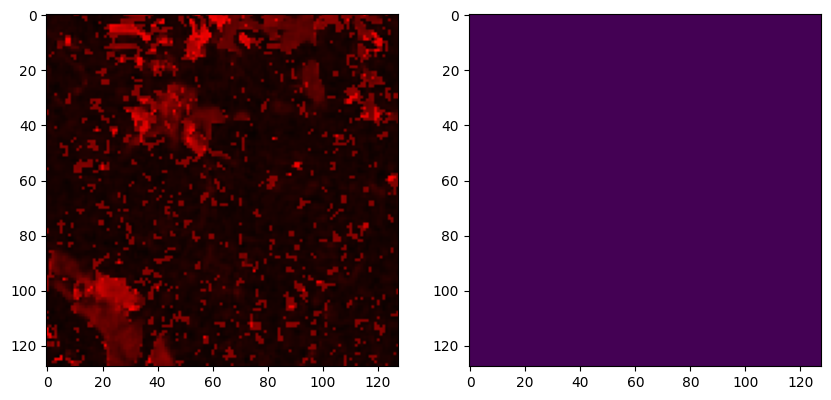

In [12]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
params, label = batch
axes[0].imshow(params[3].permute(1, 2, 0))
axes[1].imshow(label[3, 0])
plt.draw()

## Training simple U-Net

In [21]:
unet = UNet(3, [128, 256, 512, 1024], 1).to(device=th.device('cuda'))

In [22]:
validator = ValidatorOfDataset(validation_roi)
image_producer = ImageProducerFromDataArray(validation_roi[PARAMS_KEY])

fit_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
train_writer = SummaryWriter(f"/tmp/simple-unet-runs/{fit_time}/train")
valid_writer = SummaryWriter(f"/tmp/simple-unet-runs/{fit_time}/valid")
estimator = WetlandClassifier(unet, 16, log_cfg=LogConfig(train_writer, ValidationLogging(100, valid_writer, validator), ImageLogging(1000, valid_writer, image_producer)))

In [ ]:
estimator.fit(array_stream)

fitting:   2%|▍                           | 219/12500 [05:45<5:00:18,  1.47s/it]

In [13]:
estimate = apply(estimator).to(validation_roi['params'])
estimate.min().values.item()

5.453584250858512e-09

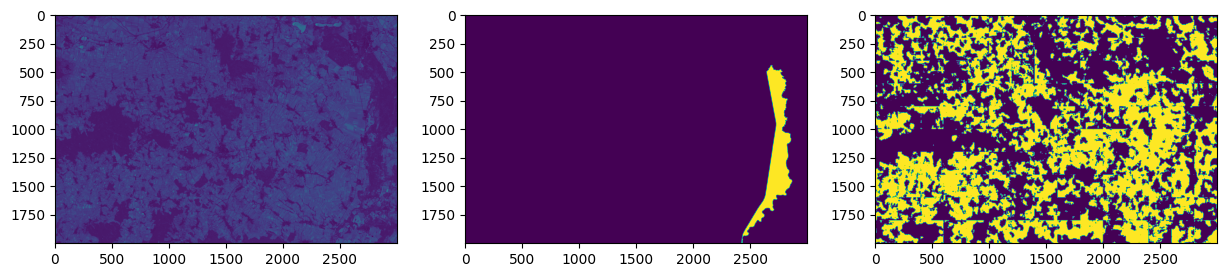

In [14]:
_, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(validation_roi[PARAMS_KEY][7])
axes[1].imshow(validation_roi[GROUND_TRUTH_KEY])
axes[2].imshow(estimate[0] > 0.6)
plt.draw()